In [11]:
import sys
sys.path.append('..')
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sfp_nsdsyn import *
import warnings
import itertools
import matplotlib as mpl

warnings.filterwarnings("ignore", category=UserWarning)
pd.options.mode.chained_assignment = None
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
output_dir='/Volumes/server/Projects/sfp_nsd/derivatives'
results_dir = os.path.join(output_dir, 'sfp_model', 'results_2D')
fig_dir = os.path.join(output_dir, 'figures')
lr = 0.0005
max_epoch = 30000
roi_list = ['V1']
vsc='pRFsize'
nsd_subj_list = [utils.sub_number_to_string(sn, 'nsdsyn') for sn in np.arange(1,9)]
broderick_sn_list = [1, 6, 7, 45, 46, 62, 64, 81, 95, 114, 115, 121]
broderick_subj_list = [utils.sub_number_to_string(i, 'broderick') for i in broderick_sn_list]
ARGS_2D = ['sub','lr','eph','roi']
roi_pal = [sns.color_palette('dark', 10)[:][k] for k in  [3,2,0]]
roi_pal.insert(0, (0.3,0.3,0.3))
stim_classes=['annulus', 'pinwheel', 'forward spiral','reverse spiral']

# Predict synthetic data based on the model parameters

```python
stim_info='/Volumes/server/Projects/sfp_nsd/natural-scenes-dataset/nsdsyn_stim_description.csv'
stim_info = vis2D.get_w_a_and_w_r_for_each_stim_class(stim_info)

ecc_range = (0, 12)
n_ecc = 121
angle_range = (np.deg2rad(0), np.deg2rad(360))
n_angle = 360
ecc_col = 'eccentricity'
angle_col = 'angle'
synthetic_df = vis2D.make_synthetic_dataframe_for_2D(stim_info,
                                                ecc_range, n_ecc,
                                                angle_range, n_angle,
                                                ecc_col, angle_col)

synthetic_df['local_ori'] = prep.calculate_local_orientation(w_a = synthetic_df['w_a'],
                                                     w_r = synthetic_df['w_r'],
                                                     retinotopic_angle=synthetic_df[angle_col],
                                                     angle_in_radians=True,
                                                     reference_frame='relative')

synthetic_df['local_ori'] = prep.calculate_local_orientation(w_a = synthetic_df['w_a'],
                                                     w_r = synthetic_df['w_r'],
                                                     retinotopic_angle=synthetic_df[angle_col],
                                                     angle_in_radians=True,
                                                     reference_frame='relative')

synthetic_df['Pv'] = synthetic_df.apply(model.get_Pv_row, 
                                        params=final_params.query('sub == "subj01" & vroinames == "V1"'), 
                                        axis=1)



# Load models

In [26]:
pt_file_list = []
for subj, roi in itertools.product(nsd_subj_list, ['V1']):
    file_name = os.path.join(output_dir, 'sfp_model', 'results_2D', 'nsdsyn', 'corrected',
                             f'model-params_lr-{lr}_eph-{max_epoch}_sub-{subj}_roi-{roi}_vs-{vsc}.pt')
    pt_file_list.append(file_name)
nsd_params = model.load_all_models(pt_file_list, *ARGS_2D)

nsd_precision_s =  pd.read_csv(os.path.join(output_dir, 'dataframes', 'nsdsyn', 'precision','corrected', f'precision-s_dset-nsdsyn_vs-pRFsize.csv'))
nsd_df = pd.merge(nsd_params, nsd_precision_s[['sub','vroinames','precision']], on=['sub','vroinames'])


In [27]:
pt_file_list = []
for subj, roi in itertools.product(broderick_subj_list, ['V1']):
    file_name = os.path.join(output_dir,'sfp_model', 'results_2D', 'broderick','corrected', f'model-params_lr-{lr}_eph-{max_epoch}_sub-{subj}_roi-{roi}_vs-{vsc}.pt')
    pt_file_list.append(file_name)
broderick_params = model.load_all_models(pt_file_list, *ARGS_2D)

broderick_precision_s =  pd.read_csv(os.path.join(output_dir, 'dataframes', 'broderick', 'precision','corrected', f'precision-s_dset-broderick_vs-pRFsize.csv'))
broderick_df = pd.merge(broderick_params, broderick_precision_s[['sub','vroinames','precision']], on=['sub','vroinames'])

In [28]:
broderick_df['dset_type'] = 'Broderick et al. V1'
nsd_df['dset_type'] = nsd_df['vroinames'].apply(lambda x: f'NSD {x}')
final_params = pd.concat((broderick_df, nsd_df), axis=0)

In [143]:
final_params.groupby('dset_type').mean()

,sigma,slope,intercept,p_1,p_2,p_3,p_4,A_1,A_2,precision
dset_type,,,,,,,,,,
Broderick et al. V1,2.185474,0.116133,0.361082,0.074682,-0.028865,0.070053,-0.005768,0.044503,-0.005137,5.993756
NSD V1,2.213854,0.143618,0.148713,0.094223,-0.030134,-0.037667,-0.080173,0.048196,-0.019006,0.396089


# Load synthetic data

In [29]:
pt_file_list = []
ecc_1, ecc_2, n_ecc = 0, 12, 121
angle_1, angle_2, n_angle = 0, 360, 361
for subj, roi, frame in itertools.product(nsd_subj_list, ['V1'], ['scaled','constant']):
    file_name = os.path.join(output_dir, 'sfp_model', 'prediction_2D', 'nsdsyn', 'corrected',
                             f'sfstimuli-{frame}_eccentricity-{ecc_1}-{ecc_2}-{n_ecc}_angle-{angle_1}-{angle_2}-{n_angle}_lr-0.0005_eph-30000_sub-{subj}_roi-{roi}_vs-pRFsize.h5')
    pt_file_list.append(file_name)
nsd_prediction = utils.load_dataframes(pt_file_list, *ARGS_2D+['sfstimuli'])

nsd_df = pd.merge(nsd_prediction, nsd_precision_s[['sub','vroinames','precision']], on=['sub','vroinames'])

In [30]:
pt_file_list = []
ecc_1, ecc_2, n_ecc = 0, 12, 121
angle_1, angle_2, n_angle = 0, 360, 361
for subj, roi, frame in itertools.product(broderick_subj_list, ['V1'], ['scaled','constant']):
    file_name = os.path.join(output_dir,  'sfp_model', 'prediction_2D', 'broderick', 'corrected',
                             f'sfstimuli-{frame}_eccentricity-{ecc_1}-{ecc_2}-{n_ecc}_angle-{angle_1}-{angle_2}-{n_angle}_lr-0.0005_eph-30000_sub-{subj}_roi-{roi}_vs-pRFsize.h5')
    pt_file_list.append(file_name)
broderick_prediction = utils.load_dataframes(pt_file_list, *ARGS_2D+['sfstimuli'])

broderick_df = pd.merge(broderick_prediction, broderick_precision_s[['sub','vroinames','precision']], on=['sub','vroinames'])

In [31]:
broderick_df['dset_type'] = 'Broderick et al. V1'
nsd_df['dset_type'] = nsd_df['vroinames'].apply(lambda x: f'NSD {x}')
final_df = pd.concat((broderick_df, nsd_df), axis=0)

# Plot each parameter and prediction

## Bandwidth and predicted tuning curves

(<Figure size 756x388.8 with 2 Axes>,
 array([<AxesSubplot:ylabel='Parameter estimates'>,
        <AxesSubplot:xlabel='Spatial frequency (cpd)', ylabel=' \nPredicted\nBOLD Response'>],
       dtype=object))

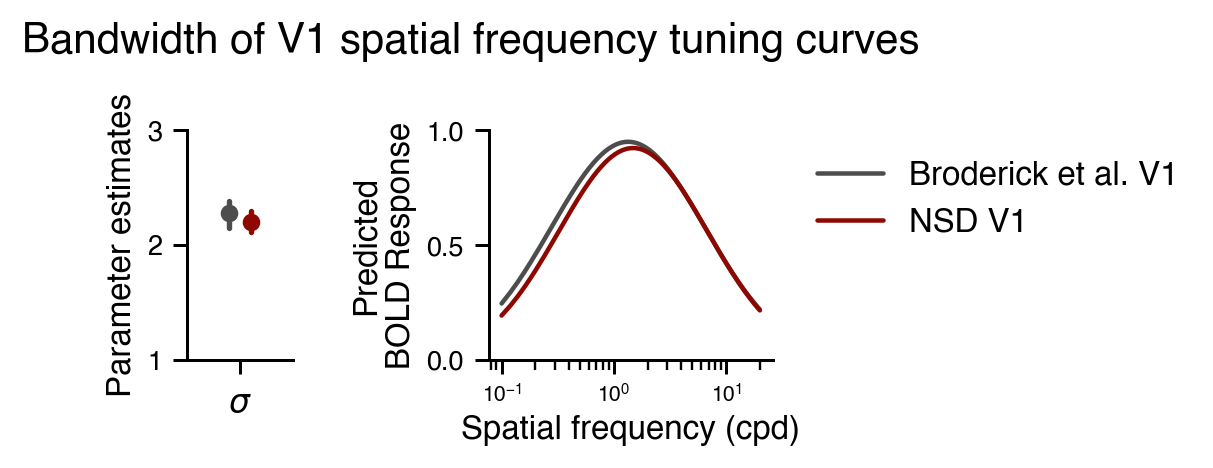

In [42]:
local_ori = np.deg2rad(90)
ecc = 5
angle = np.deg2rad(180)

tmp, hue_order, pal = vis2D.filter_for_goal(final_params, 'replication')
weighted_mean_df = vis2D.get_weighted_average_of_params(tmp, ['dset_type'], ecc, angle, local_ori)

vis2D.plot_param_and_prediction(params_df=tmp, params=['sigma'], 
                                hue='dset_type', hue_order=hue_order,
                                prediction_df=weighted_mean_df, prediction_y=None,
                                pal=pal,
                                params_ylim=(1, 3), params_yticks=[1,2,3],
                                prediction_ylim=None, prediction_yticks=None,
                                title='Bandwidth of V1 spatial frequency tuning curves',
                                prediction_ylabel='Preferred period (deg)',
                                figsize=(3.5, 1.8), width_ratios=[1.5, 4], 
                                save_path=os.path.join(fig_dir, 'sfp_model', 'results_2D', 'replication', 'param-bandwidth_goal-replication_lr-0.0005_eph-30000_vs-pRFsize.svg'))


In [11]:
new_df = vis2D.calculate_within_subject_error_for_V123(tmp, 'sigma', subject='sub', roi='vroinames')
new_df = pd.merge(new_df, tmp[['sub','precision']], on='sub')


## slope and intercept

(<Figure size 972x388.8 with 2 Axes>,
 array([<AxesSubplot:ylabel='Parameter estimates'>,
        <AxesSubplot:xlabel='Eccentricity (deg)', ylabel='Preferred period (deg)'>],
       dtype=object))

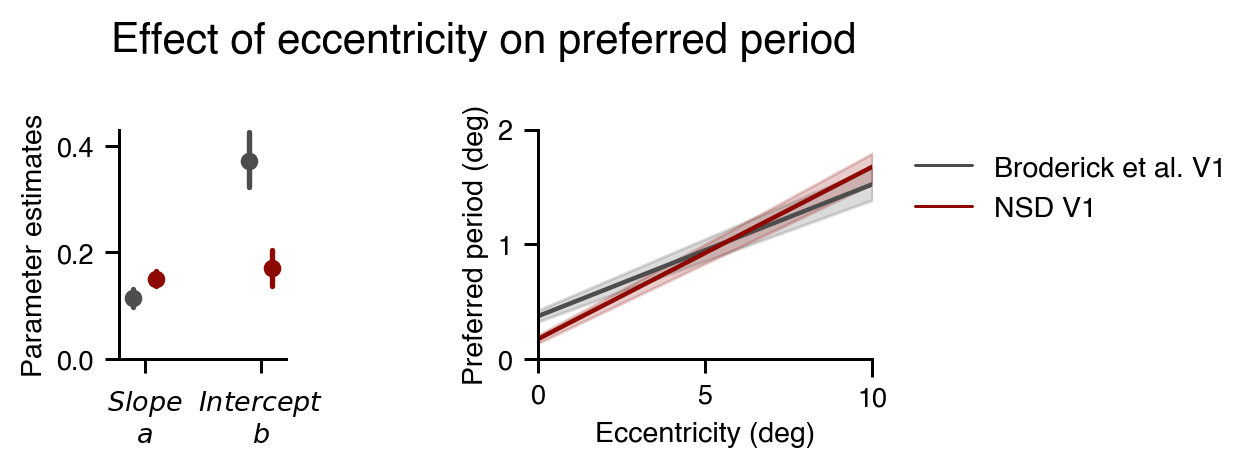

In [115]:
tmp, hue_order, pal = vis2D.filter_for_goal(final_params, 'replication')
ecc_df, _, _ = vis2D.filter_for_goal(final_df, 'replication')

ecc_list=[0,10]
ecc_df = ecc_df.query('sfstimuli == "scaled" & eccentricity in @ecc_list')
ecc_df = ecc_df.groupby(['sub','dset_type','vroinames','eccentricity']).mean().reset_index()

vis2D.plot_param_and_prediction(params_df=tmp, params=['slope','intercept'], 
                                hue='dset_type', hue_order=hue_order,
                                prediction_df=ecc_df, prediction_y='Pv',
                                pal=pal,
                                params_ylim=(0, 0.43), params_yticks=[0, 0.2, 0.4],
                                prediction_ylim=(0,2), prediction_yticks=[0,1,2],
                                prediction_ylabel='Preferred period (deg)',
                                figsize=(4.5, 1.8), width_ratios=[1,2], 
                                title='Effect of eccentricity on preferred period',
                                save_path=os.path.join(fig_dir, 'sfp_model', 'results_2D', 'replication', 'param-ecceffect_goal-replication_lr-0.0005_eph-30000_vs-pRFsize.svg'))



# Plot preferred period for each parameter

## P1: Horizontal gratings vs. vertical gratings

(<Figure size 756x464.4 with 2 Axes>,
 array([<AxesSubplot:ylabel='Parameter estimates'>,
        <AxesSubplot:xlabel='Eccentricity (deg)', ylabel='Difference (deg)'>],
       dtype=object))

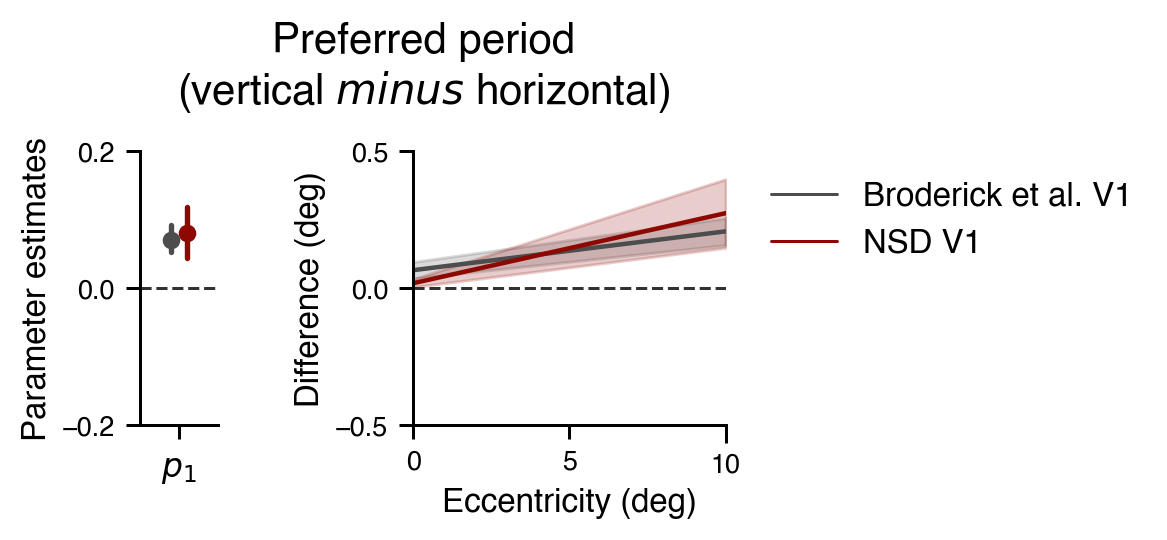

In [44]:
tmp, hue_order, pal = vis2D.filter_for_goal(final_params, 'replication')
ecc_list = [0,10]
ecc_df, _, _ = vis2D.filter_for_goal(final_df, 'replication')
ecc_df = ecc_df.query('sfstimuli == "constant"')
ecc_df = ecc_df.query('eccentricity in @ecc_list')

p_df = vis2D.get_Pv_difference(ecc_df, 'vertical', 'horizontal', 
                               to_group=['sub', 'eccentricity', 'dset_type', 'vroinames'], orientation_col='names')

vis2D.plot_param_and_prediction(params_df=tmp, params=['p_1'], 
                          params_ylim=(-0.2, 0.2), params_yticks= [-0.2,0,0.2], 
                          prediction_df=p_df, prediction_y='Pv_diff',
                          prediction_ylim=(-0.5, 0.5), prediction_yticks= [-0.5,0,0.5], 
                          pal=pal, hue='dset_type', hue_order=hue_order,
                          prediction_ylabel= 'Difference (deg)',
                          title='Preferred period\n(vertical ''$\it{minus}$' ' horizontal)',
                          figsize=(3.5, 2.15), width_ratios=[1, 4], save_path=os.path.join(fig_dir, 'sfp_model', 'results_2D', 'replication','param-p1_goal-replication_lr-0.0005_eph-30000_vs-pRFsize.svg'))


## P2: cardinal vs. oblique

(<Figure size 756x464.4 with 2 Axes>,
 array([<AxesSubplot:ylabel='Parameter estimates'>,
        <AxesSubplot:xlabel='Eccentricity (deg)', ylabel='Difference (deg)'>],
       dtype=object))

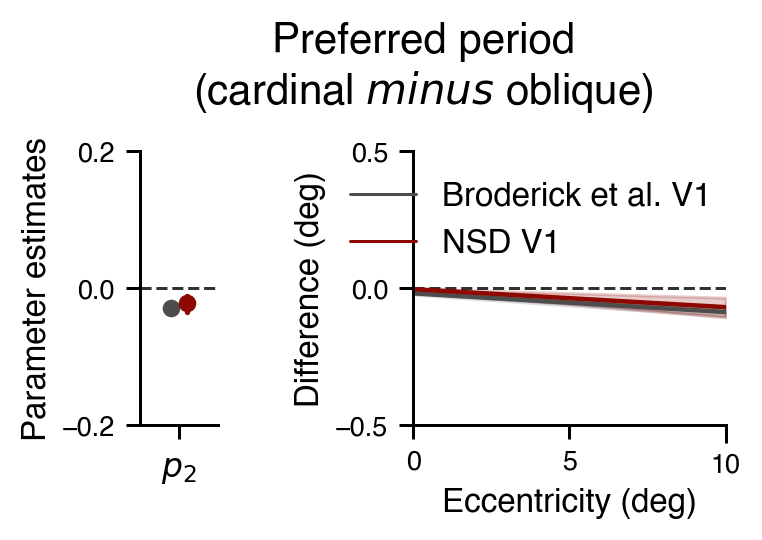

In [53]:
tmp, hue_order, pal = vis2D.filter_for_goal(final_params, 'replication')
ecc_df, _, _ = vis2D.filter_for_goal(final_df, 'replication')
ecc_df = ecc_df.query('eccentricity in @ecc_list')
ecc_df = ecc_df.query('sfstimuli == "constant"')

p_df = vis2D.get_Pv_difference(ecc_df, 'cardinal', 'oblique', 
                               to_group=['sub', 'eccentricity', 'dset_type', 'vroinames'], orientation_col='names')

vis2D.plot_param_and_prediction(params_df=tmp, params=['p_2'], 
                          params_ylim=(-0.2, 0.2), params_yticks= [-0.2,0,0.2], 
                          prediction_df=p_df, prediction_y='Pv_diff',
                          prediction_ylim=(-0.5, 0.5), prediction_yticks= [-0.5,0,0.5], 
                          pal=pal, hue='dset_type', hue_order=hue_order,
                          prediction_ylabel= 'Difference (deg)',
                          title='Preferred period\n(cardinal ''$\it{minus}$' ' oblique)',
                          figsize=(3.5, 2.15), width_ratios=[1, 4], save_path=os.path.join(fig_dir, 'sfp_model', 'results_2D', 'replication','param-p2_goal-replication_lr-0.0005_eph-30000_vs-pRFsize.svg'))

## P3: Annulus vs. pinwheel

In [140]:
tmp.query('dset_type == "NSD V1"').p_3.mean()

-0.037667435

In [148]:
stim_info='/Volumes/server/Projects/sfp_nsd/natural-scenes-dataset/nsdsyn_stim_description_corrected.csv'
stim_info = vis2D.get_w_a_and_w_r_for_each_stim_class(stim_info)
stim_info = vis2D.make_synthetic_dataframe_for_2D(stim_info,
                                            [0,10], 2,
                                            [0,180], 2,
                                            'eccentricity', 'angle')
merged_df['local_ori'] = calculate_local_orientation(stim_info['w_a'], stim_info['w_r'],
                                                     retinotopic_angle=stim_info['angle'],
                                                     angle_in_radians=True,
                                                     sfstimuli=sfstimuli)

,names,w_r,w_a
0,pinwheel,0.0,-6.0
24,forward spiral,4.0,-4.0
48,annulus,6.0,-0.0
72,reverse spiral,4.0,4.0


In [147]:
ww = final_params.query('dset_type == "NSD V1"')
local_ori = np.deg2rad(90)
ecc = 5
angle = np.deg2rad(180)


,sigma,slope,intercept,p_1,p_2,p_3,p_4,A_1,A_2,sub,lr_rate,max_epoch,vroinames,precision,dset_type
0,2.536201,0.139149,0.271883,-0.072822,0.003162,-0.255981,0.014144,0.080796,-0.015730,subj01,0.0005,30000,V1,0.608591,NSD V1
1,1.938979,0.148039,0.082835,0.147832,-0.039300,-0.038702,-0.000303,0.030481,-0.002720,subj02,0.0005,30000,V1,0.416201,NSD V1
2,2.352920,0.056186,0.105715,0.152566,-0.006781,0.065288,-0.066534,0.006534,-0.023752,subj03,0.0005,30000,V1,0.212653,NSD V1
3,1.942852,0.206604,0.119989,0.133012,-0.023695,0.069233,-0.062159,0.076657,-0.018837,subj04,0.0005,30000,V1,0.610271,NSD V1
4,2.365176,0.118251,0.130331,0.028012,-0.033951,-0.117134,-0.089555,0.038780,-0.013571,subj05,0.0005,30000,V1,0.313483,NSD V1
5,2.159858,0.148343,0.296055,0.104046,0.015309,0.109438,-0.114986,0.082849,-0.038815,subj06,0.0005,30000,V1,0.560760,NSD V1
6,2.070098,0.122374,0.083634,0.138148,-0.125115,0.043045,-0.178968,-0.001480,-0.008419,subj07,0.0005,30000,V1,0.246561,NSD V1
7,2.344747,0.209995,0.099267,0.122993,-0.030700,-0.176526,-0.143022,0.070950,-0.030201,subj08,0.0005,30000,V1,0.200196,NSD V1


In [132]:

p_df = vis2D.get_Pv_difference(ecc_df, 'annulus', 'pinwheel', 
                               to_group=['sub', 'eccentricity', 'dset_type','vroinames'], orientation_col='names')

(<Figure size 756x464.4 with 2 Axes>,
 array([<AxesSubplot:ylabel='Parameter estimates'>,
        <AxesSubplot:xlabel='Eccentricity (deg)', ylabel='Difference (deg)'>],
       dtype=object))

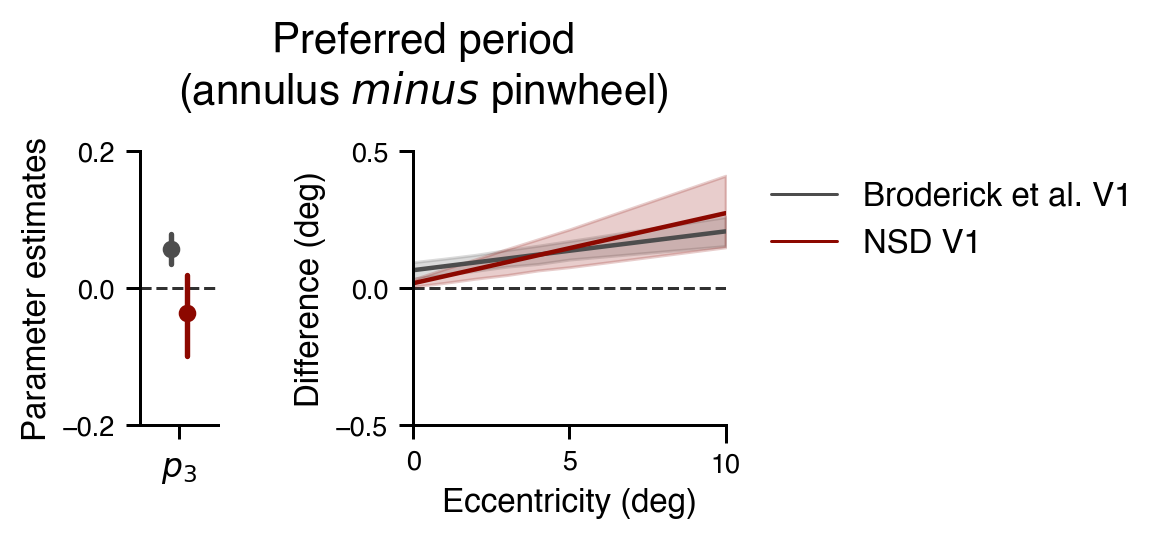

In [139]:
tmp, hue_order, pal = vis2D.filter_for_goal(final_params, 'replication')
ecc_df, _, _ = vis2D.filter_for_goal(final_df, 'replication')
ecc_df = ecc_df.query('eccentricity in [0,1,2,3,4,5,10]')

p_df = vis2D.get_Pv_difference(ecc_df, 'annulus', 'pinwheel', 
                               to_group=['sub', 'eccentricity', 'dset_type','vroinames'], orientation_col='names')

vis2D.plot_param_and_prediction(params_df=tmp, params=['p_3'], 
                          params_ylim=(-0.2, 0.2), params_yticks= [-0.2,0,0.2], 
                          prediction_df=p_df, prediction_y='Pv_diff',
                          prediction_ylim=(-0.5, 0.5), prediction_yticks= [-0.5,0,0.5], 
                          pal=pal, hue='dset_type', hue_order=hue_order,
                          prediction_ylabel= 'Difference (deg)',
                          title='Preferred period\n(annulus ''$\it{minus}$' ' pinwheel)',
                          figsize=(3.5, 2.15), width_ratios=[1, 4], save_path=os.path.join(fig_dir, 'sfp_model', 'results_2D', 'replication','param-p3_goal-replication_lr-0.0005_eph-30000_vs-pRFsize.svg'))


## P4: Spirals vs. annulus/pinwheel

(<Figure size 756x464.4 with 2 Axes>,
 array([<AxesSubplot:ylabel='Parameter estimates'>,
        <AxesSubplot:xlabel='Eccentricity (deg)', ylabel='Difference (deg)'>],
       dtype=object))

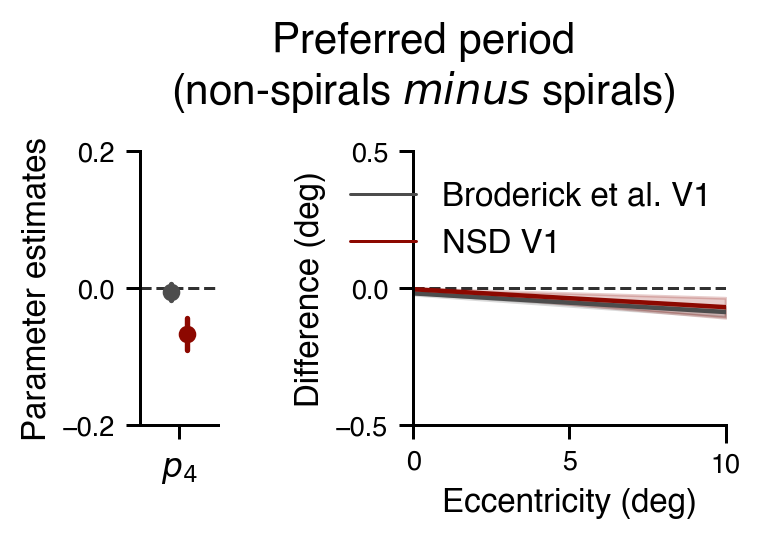

In [51]:
tmp, hue_order, pal = vis2D.filter_for_goal(final_params, 'replication')
ecc_df, _, _ = vis2D.filter_for_goal(final_df, 'replication')
ecc_df = ecc_df.query('eccentricity in @ecc_list')

p_df = vis2D.get_Pv_difference(ecc_df, 'non-spirals', 'spirals', 
                               to_group=['sub', 'eccentricity', 'dset_type', 'vroinames'], orientation_col='names')

vis2D.plot_param_and_prediction(params_df=tmp, params=['p_4'], 
                          params_ylim=(-0.2, 0.2), params_yticks= [-0.2,0,0.2], 
                          prediction_df=p_df, prediction_y='Pv_diff',
                          prediction_ylim=(-0.5, 0.5), prediction_yticks= [-0.5,0,0.5], 
                          pal=pal, hue='dset_type', hue_order=hue_order,
                          prediction_ylabel= 'Difference (deg)',
                          title='Preferred period\n(non-spirals ''$\it{minus}$' ' spirals)',
                          figsize=(3.5, 2.15), width_ratios=[1, 4], save_path=os.path.join(fig_dir, 'sfp_model', 'results_2D', 'replication','param-p4_goal-replication_lr-0.0005_eph-30000_vs-pRFsize.svg'))

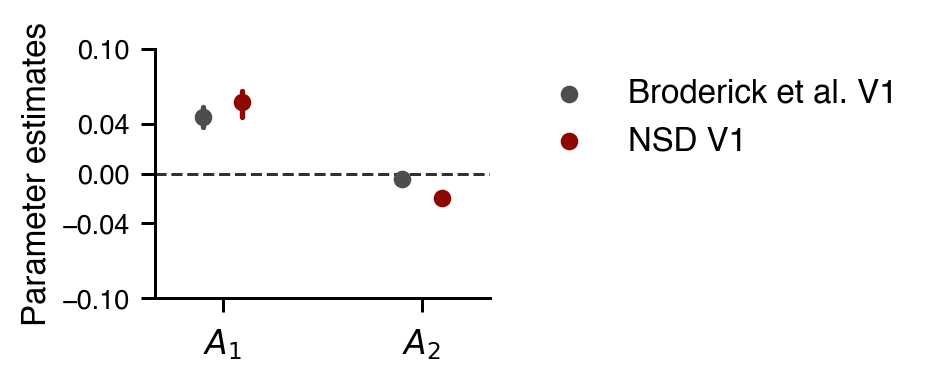

In [73]:
tmp, hue_order, pal = vis2D.filter_for_goal(final_params, 'replication')

fig, ax = plt.subplots(1, 1, figsize=(2, 1.5),
                         sharey=False, sharex=False)

g = vis2D.plot_precision_weighted_avg_parameter(tmp, ['A_1','A_2'], 'dset_type', hue_order, ax=ax, ylim=(-0.1,0.1), yticks=[-0.1,-0.04,0,0.04,0.1], pal=pal)

g.margins(x=0.2)
g.legend(bbox_to_anchor=(1.05, 1), loc='best', frameon=False)
utils.save_fig(os.path.join(fig_dir, 'sfp_model', 'results_2D', 'replication','param-A12_goal-replication_lr-0.0005_eph-30000_vs-pRFsize.svg'))

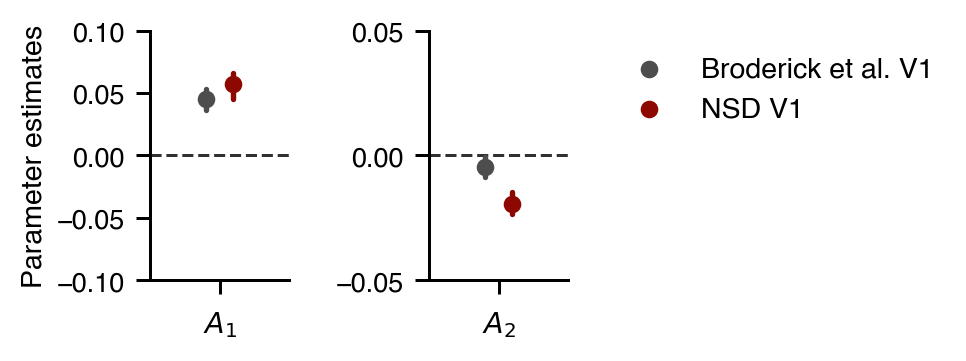

In [114]:
tmp, hue_order, pal = vis2D.filter_for_goal(final_params, 'replication')

fig, ax = plt.subplots(1, 2, figsize=(2.5, 1.5),
                         sharey=False, sharex=False)

g = vis2D.plot_precision_weighted_avg_parameter(tmp, ['A_1'], 'dset_type', hue_order, ax=ax[0], ylim=(-0.1,0.1), yticks=[-0.1,-0.05,0,0.05,0.1], pal=pal)
g.legend_.remove()
g = vis2D.plot_precision_weighted_avg_parameter(tmp, ['A_2'], 'dset_type', hue_order, ax=ax[1], ylim=(-0.05,0.05), yticks=[-0.05,0,0.05], pal=pal)
#g.margins(x=0.2)
g.set_ylabel('')
g.legend(bbox_to_anchor=(3.8, 1), loc='best', frameon=False)
fig.subplots_adjust(wspace=1)
utils.save_fig(os.path.join(fig_dir, 'sfp_model', 'results_2D', 'replication','param-A12_goal-replication_lr-0.0005_eph-30000_vs-pRFsize.svg'))

(<Figure size 1857.6x324 with 5 Axes>,
 array([<AxesSubplot:ylabel='Parameter estimates'>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>], dtype=object))

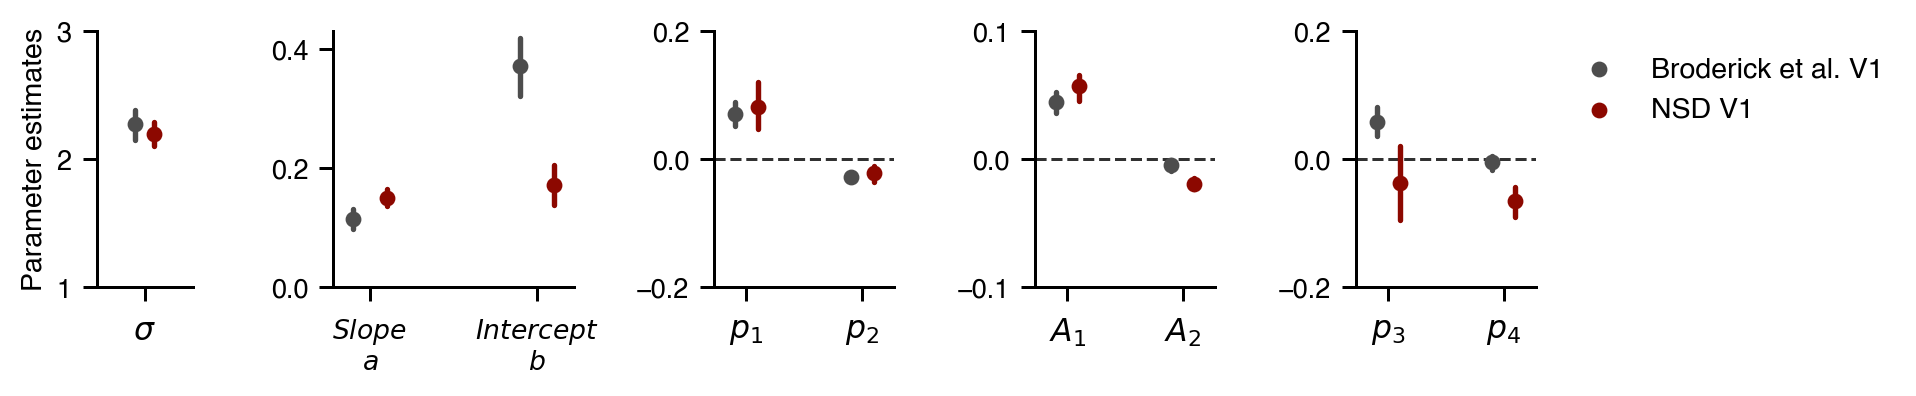

In [113]:
tmp, hue_order, pal = vis2D.filter_for_goal(final_params, 'replication')
ylim_list = [(1, 3), (0, 0.43), (-0.2, 0.2),(-0.1,0.1), (-0.2, 0.2)]
yticks_list=  [[1,2,3], [0, 0.2, 0.4], [-0.2,0,0.2], [-0.1,0,0.1], [-0.2,0,0.2]]
params_list = [['sigma'], ['slope', 'intercept'], ['p_1', 'p_2'], ['A_1','A_2'], ['p_3', 'p_4']]
title_list = ['Bandwidth', 'Eccentricity effect', 'Absolute orientation effect\non preferred period', 'Amplitude', 'Relative orientation effect\non preferred period']
vis2D.make_param_summary_fig(tmp, 'dset_type', hue_order, pal, 
                           params_list, ylim_list, yticks_list, title_list=None,
                           width_ratios=(0.8,2,1.5,1.5,1.5), fig_size=(8.6, 1.5),
                           scale=0.9,
                           save_path=os.path.join(fig_dir, 'sfp_model', 'results_2D', 'replication','summary_goal-replication_lr-0.0005_eph-30000_vs-pRFsize.svg'))
#g.margins(x=0.1)